## Application of ALS and SVD on Movielens

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%%time
#df = load_movielens_data('ml-1m')
df = load_movielens_data('ml-100k')
df.head()

CPU times: user 18.5 ms, sys: 19.7 ms, total: 38.1 ms
Wall time: 37.3 ms


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
%%time
dfshort = df[df['rating'] > 0]
cf = UserItemInteractions(
    name='MovieLens-1m',
    users = dfshort['user_id'], 
    items = dfshort['item_id'],
    min_num_rating_per_user=30,
    min_num_rating_per_item=10
)
cf.print_memory_usage()

--- Memory usage for MovieLens-1m:
Sparse User-Item matrix = 0.09 MB
User-Item dataframe df = 2.85 MB
Item dataframe df_item = 0.03 MB
Item dataframe df_user = 0.02 MB
---
CPU times: user 73 ms, sys: 812 µs, total: 73.8 ms
Wall time: 71.9 ms


In [5]:
%%time
cf.generate_train_test(user_test_ratio = 0.2)

CPU times: user 1.92 s, sys: 0 ns, total: 1.92 s
Wall time: 1.93 s


In [6]:
als = MF_ALS(num_features=10, reg_lambda=0., num_iters=100, initial_std=0.1, seed=None)

In [7]:
als.fit(cf.R_train)

In [8]:
ndcg_score = cf.get_ndcg_metric(
    user_mat = als.user_mat,
    item_mat=als.item_mat,
    num_items = 10,
    test=True,
    truncate=True
)

In [9]:
ndcg_score

0.45679663853798047

## Effect of num of features on ndcg

In [10]:
num_features_list = np.arange(1,100,4)
ndcg_list = []
for num_features in num_features_list:
    print(num_features, end="-", flush=True)
    als = MF_ALS(
        num_features=num_features, 
        reg_lambda=0., 
        num_iters=10, 
        initial_std=0.1, 
        seed=None
    )
    als.fit(cf.R_train)
    als_ndcg_func = partial(
        cf.get_ndcg_metric, 
        user_mat = als.user_mat, 
        item_mat=als.item_mat, 
        num_items = 10
    )
    svd = MF_SVD(num_features=num_features, num_iters=100, seed=None)
    svd.fit(cf.R_train)
    svd_ndcg_func = partial(
        cf.get_ndcg_metric, 
        user_mat = svd.user_mat, 
        item_mat=svd.item_mat, 
        num_items = 10
    )
    result_dict={
        'num_features': num_features,
        'als_test': als_ndcg_func(test=True),
        'als_train': als_ndcg_func(test=False),
        'svd_test': svd_ndcg_func(test=True),
        'svd_train': svd_ndcg_func(test=False)
    }
    ndcg_list.append(result_dict)
ndcg_df = pd.DataFrame(ndcg_list)

1-5-9-13-17-21-25-29-33-37-41-45-49-53-57-61-65-69-73-77-81-85-89-93-97-

In [11]:
ndcg_df.head()

,num_features,als_test,als_train,svd_test,svd_train
0,1,0.269689,0.458040,0.269689,0.458040
1,5,0.411076,0.665152,0.409970,0.658617
2,9,0.447496,0.715987,0.451182,0.717836
3,13,0.455998,0.754659,0.462949,0.753311
4,17,0.465561,0.797055,0.462804,0.797053


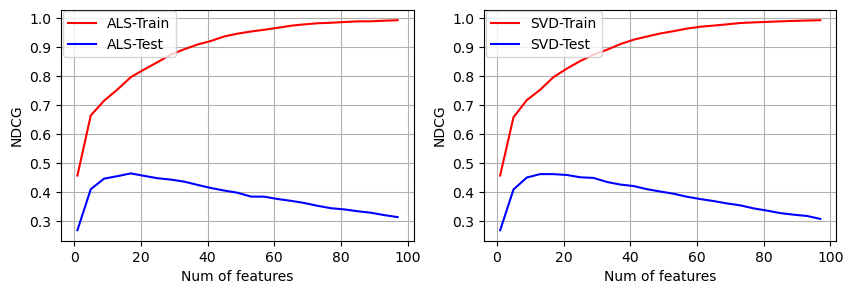

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(ndcg_df['num_features'], ndcg_df['als_train'], '-r', label='ALS-Train')
ax[0].plot(ndcg_df['num_features'], ndcg_df['als_test'], '-b', label='ALS-Test')
ax[1].plot(ndcg_df['num_features'], ndcg_df['svd_train'], '-r', label='SVD-Train')
ax[1].plot(ndcg_df['num_features'], ndcg_df['svd_test'], '-b', label='SVD-Test')
for iax in ax:
    iax.grid(True)
    #iax.set_ylim([0, 1])
    iax.set_ylabel('NDCG')
    iax.set_xlabel('Num of features')
    iax.legend(loc=2, borderaxespad=0.1)

## Conclusions
- Around 10-20 features seems to provide best NDCG for Movielens-100k data
- ALS and SVD have same solution when using no regularization on ALS cost function
- Changing the num_items when computing NDCG just scales the NDCG-num_of_features relation
- Adding reularization to ALS makes sure it does not overfit for large num of features
- ALS with regularization has the same optimal NDCG and num of features as SVD
- ALS solution seems to converging at around 10 iterations